In [1]:
# %load ../firstcell.txt
%reload_ext autoreload
%autoreload 2


import numpy as np
import matplotlib.pyplot as plt
# from statsmodels.formula.api import ols
# import statsmodels.api as sm
# import seaborn as sns
import pandas as pd
plt.rcParams['figure.dpi']=150
import geopandas as gpd

In [37]:
with open('../united_names_datasets/REAMDE.txt','r') as file:
    print(file.read())

"tradeMatrix_PWG" son los datos de comercio de comida pero con los nombres de los paises en comun de los 4 datasets usado, a saber, GDP, Population, world map y dataset de comercio de comida.

Si alguna vez necesito calcular antifragilidad para cualquier caso, seria bueno usar este dataset para tener nombres homonegeneos y hacer mapas de manera directa


In [2]:
df=pd.read_csv('../united_names_datasets/tradeMatrix_PWG.csv')

In [3]:
#Import shp file of the world and ignore Antarctica
world = gpd.read_file('../world_shapefiles/Longitude_Graticules_and_World_Countries_Boundaries-shp/99bfd9e7-bb42-4728-87b5-07f8c8ac631c2020328-1-1vef4ev.lu5nk.shp')
world = world[world.CNTRY_NAME !='Antarctica']

In [4]:
world.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

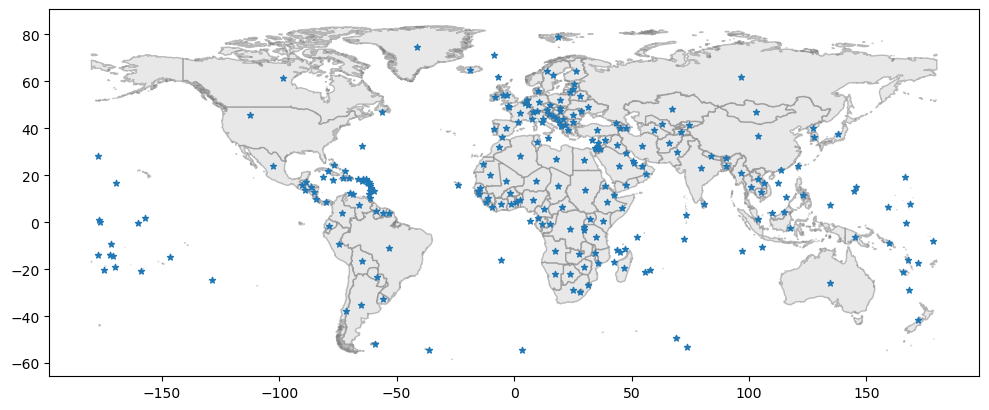

In [153]:
fig,ax=plt.subplots(figsize=(12,10))
world.plot(color='lightgrey',
                      edgecolor='grey',
                      alpha=.5,
                      ax=ax)

centers=world.centroid

# Add another layer using the same ax
centers.plot(markersize=20,ax=ax,marker='*')

In [5]:
world_meters=world.to_crs(epsg=32663)

In [6]:
world_meters.crs

<Projected CRS: EPSG:32663>
Name: WGS 84 / World Equidistant Cylindrical
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Coordinate Operation:
- name: World Equidistant Cylindrical
- method: Equidistant Cylindrical
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

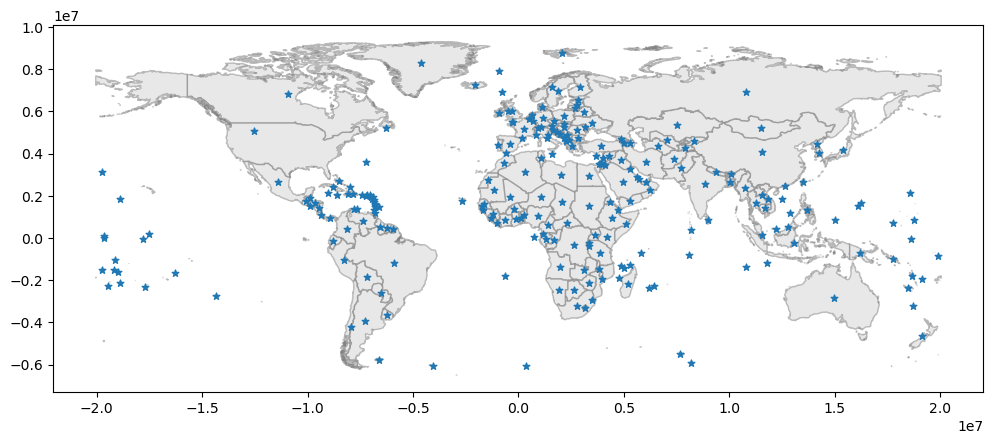

In [155]:
fig,ax=plt.subplots(figsize=(12,10))
world_meters.plot(color='lightgrey',
                      edgecolor='grey',
                      alpha=.5,
                      ax=ax)

centers=world_meters.centroid

# Add another layer using the same ax
centers.plot(markersize=25,ax=ax,marker='*')
# plt.savefig('centroids.png')

In [48]:
#compute pair-distance combinations of countries.
countries=df.exporter.unique()

countriesexp=[]
countriesimp=[]
distances=[]
s=0

for country1 in countries:
    countries_tocompare=df[df.exporter==country1].importer.unique()
    for country2 in countries_tocompare:
        
        #get distances between centroids of each country
        
        center1=world_meters[world_meters.CNTRY_NAME==country1].centroid
        center2=world_meters[world_meters.CNTRY_NAME==country2].centroid
        
        try:
            distance=center1.values.distance(center2.values)/(1e3)
        except ValueError as e:
            continue 
         
        try:
            distances.append(distance[0])
            countriesexp.append(country1)
            countriesimp.append(country2)
        except IndexError as e: # Show pairs of countries which exhibits an error calculating their distances
            print(country1,'-------',country2)
            print(center1,'-------',center2)

Belgium-Luxembourg ------- China, Hong Kong SAR
GeoSeries([], dtype: geometry) ------- GeoSeries([], dtype: geometry)
Belgium-Luxembourg ------- Cote d'Ivoire
GeoSeries([], dtype: geometry) ------- GeoSeries([], dtype: geometry)
Belgium-Luxembourg ------- Ethiopia PDR
GeoSeries([], dtype: geometry) ------- GeoSeries([], dtype: geometry)
Belgium-Luxembourg ------- Réunion
GeoSeries([], dtype: geometry) ------- GeoSeries([], dtype: geometry)
Belgium-Luxembourg ------- Serbia and Montenegro
GeoSeries([], dtype: geometry) ------- GeoSeries([], dtype: geometry)
Belgium-Luxembourg ------- Yugoslav SFR
GeoSeries([], dtype: geometry) ------- GeoSeries([], dtype: geometry)
China, Macao SAR ------- China, Hong Kong SAR
GeoSeries([], dtype: geometry) ------- GeoSeries([], dtype: geometry)
Myanmar ------- Belgium-Luxembourg
GeoSeries([], dtype: geometry) ------- GeoSeries([], dtype: geometry)
Myanmar ------- China, Hong Kong SAR
GeoSeries([], dtype: geometry) ------- GeoSeries([], dtype: geometry)

In [51]:
df_distances=pd.DataFrame({'importer':countriesimp,'exporter':countriesexp,'distance_Km':distances})

In [93]:
# df_distances.to_csv('distances_countries_inKM.csv')

In [7]:
df_distances=pd.read_csv('distances_countries_inKM.csv',index_col=0)

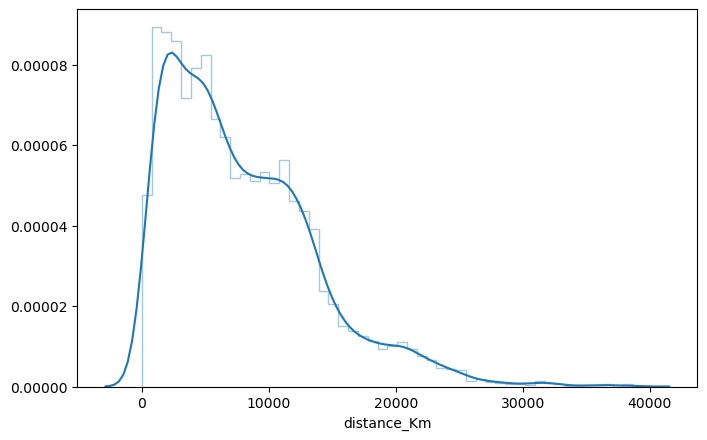

In [156]:
fig,ax=plt.subplots(figsize=(8,5))
sns.distplot(df_distances.distance_Km,ax=ax,hist_kws={"histtype": "step"})
plt.savefig('distribucion_distancias.png')

In [21]:
df_distances

,importer,exporter,distance_Km
0,Afghanistan,Argentina,16512.332211
1,Albania,Argentina,12750.948242
2,Algeria,Argentina,10343.796015
3,Antigua and Barbuda,Argentina,5873.677383
4,Armenia,Argentina,14872.769716
...,...,...,...
12276,New Zealand,Tonga,38658.364716
12277,Pakistan,Federated States of Micronesia,10355.914193
12278,Poland,Federated States of Micronesia,16392.052248
12279,South Korea,Anguilla,21346.177084


In [8]:
exporter_distances=df_distances.groupby(['exporter']).agg([np.sum,np.mean])
exporter_distances.head()

distance_Km              
                          sum          mean
exporter                                   
Afghanistan     346946.727651   7228.056826
Albania         110899.946921   3824.136101
Algeria         132796.209215   3794.177406
American Samoa  346665.890519  19259.216140
Andorra          26274.887867   4379.147978

In [9]:
exporter_distances.columns=exporter_distances.columns.get_level_values(1)
exporter_distances.reset_index(inplace=True)
exporter_distances

,exporter,sum,mean
0,Afghanistan,3.469467e+05,7228.056826
1,Albania,1.108999e+05,3824.136101
2,Algeria,1.327962e+05,3794.177406
3,American Samoa,3.466659e+05,19259.216140
4,Andorra,2.627489e+04,4379.147978
...,...,...,...
214,Vietnam,1.671754e+06,10926.496009
215,Western Sahara,6.280210e+03,6280.210452
216,Yemen,1.286195e+05,5144.778780
217,Zambia,3.122742e+05,6245.484226


In [10]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [11]:
world_meters.head()

,OBJECTID,CNTRY_NAME,geometry
0,1,Aruba,"POLYGON ((-7779254.556 1381598.437, -7786458.3..."
1,2,Antigua and Barbuda,"MULTIPOLYGON (((-6872741.975 1952605.545, -687..."
2,3,Afghanistan,"POLYGON ((6821275.225 3963780.538, 6823482.132..."
3,4,Algeria,"POLYGON ((-573533.033 3359674.498, -572089.488..."
4,5,Azerbaijan,"MULTIPOLYGON (((5012252.392 4567499.721, 50104..."


In [12]:
type(world_meters)

geopandas.geodataframe.GeoDataFrame

In [13]:
exporter_distances.rename(columns={'exporter':'CNTRY_NAME'},inplace=True)
world_meters=pd.merge_ordered(world_meters,exporter_distances,on='CNTRY_NAME')

In [14]:
world_meters.head()

,OBJECTID,CNTRY_NAME,geometry,sum,mean
0,3,Afghanistan,"POLYGON ((6821275.225 3963780.538, 6823482.132...",346946.727651,7228.056826
1,6,Albania,"POLYGON ((2314546.339 4500818.605, 2314022.746...",110899.946921,3824.136101
2,4,Algeria,"POLYGON ((-573533.033 3359674.498, -572089.488...",132796.209215,3794.177406
3,10,American Samoa,"POLYGON ((-19007123.613 -1600279.467, -1900773...",346665.890519,19259.216140
4,8,Andorra,"POLYGON ((160949.416 4742426.710, 165479.505 4...",26274.887867,4379.147978


In [15]:
world_meters.set_geometry('geometry',inplace=True)

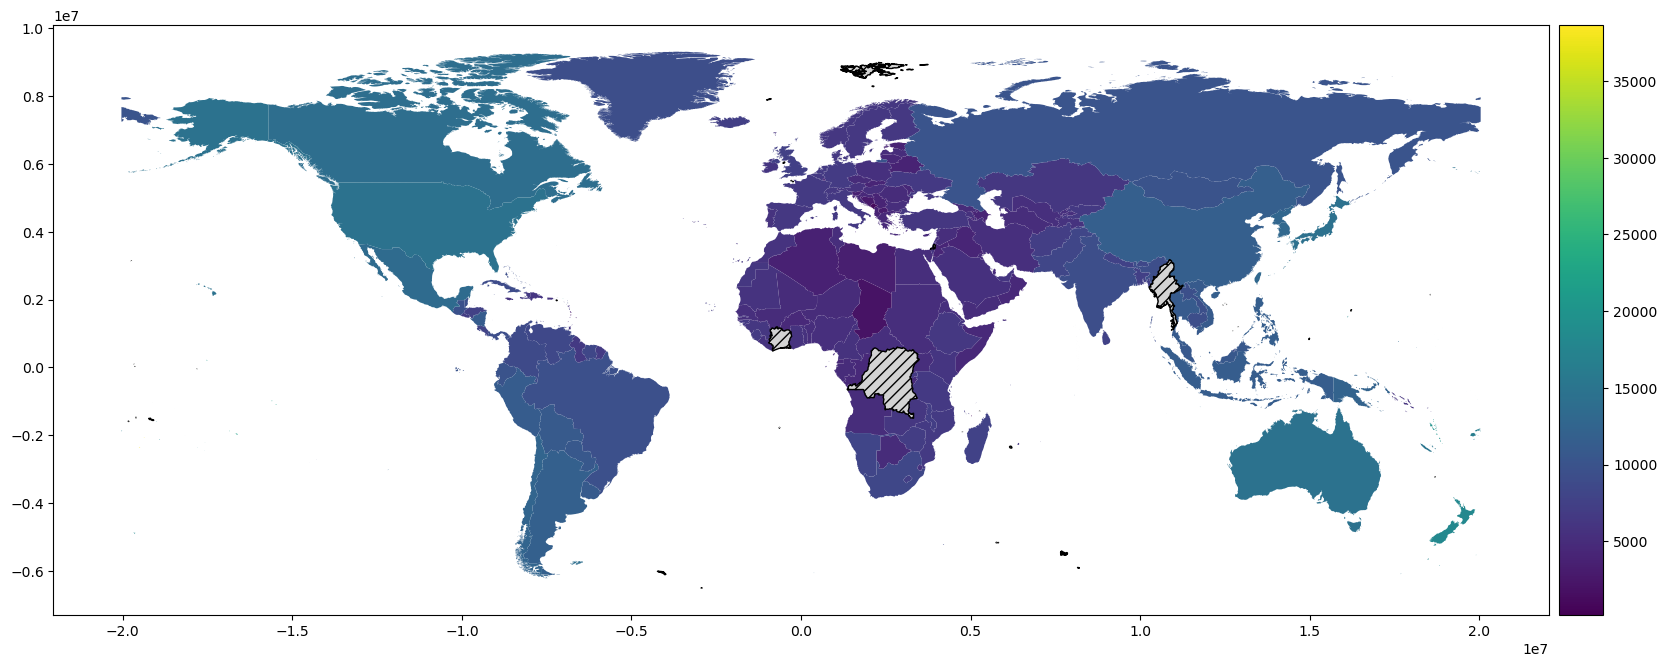

In [19]:
missing_kwds={"color": "lightgrey","edgecolor": "black","hatch": "///","label": "Missing values"}

fig,ax = plt.subplots(figsize=(20,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right",size="3%",pad=0.1)

world_meters.plot(column='mean',ax=ax,missing_kwds=missing_kwds,legend=True,cax=cax)
# plt.savefig('distancias_plots/mean_distanceMAP.png')

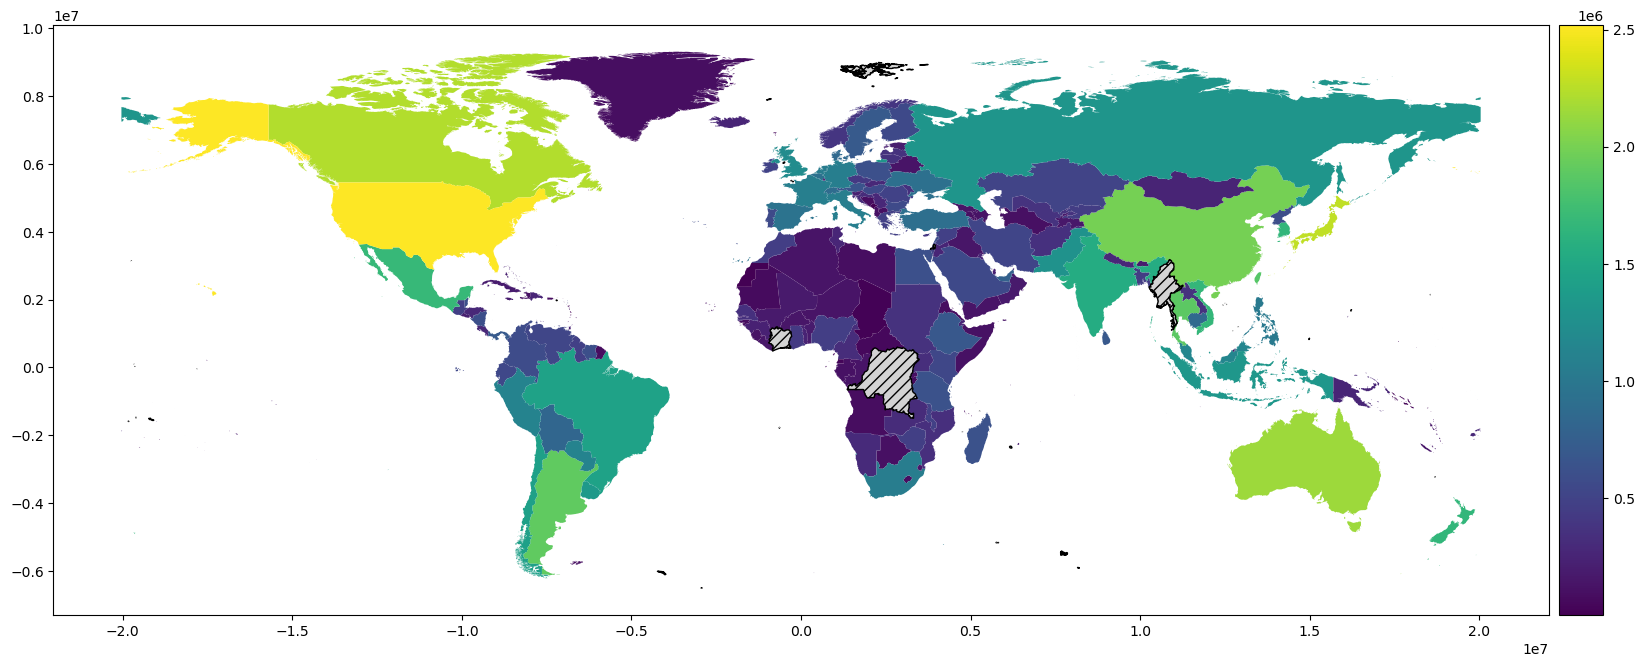

In [20]:
fig,ax = plt.subplots(figsize=(20,10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right",size="3%",pad=0.1)

world_meters.plot(column='sum',ax=ax,legend=True,cax=cax,missing_kwds=missing_kwds)
# plt.savefig('distancias_plots/sum_distanceMAP.png')

## preprocessing distances df

In [3]:
df_distances=pd.read_csv('distances_countries_inKM.csv',index_col=0)
df=pd.read_csv('../united_names_datasets/tradeMatrix_PWG.csv')

In [310]:
# filter only quantity column to reduce size of data.
# group by year, then by exporter 
yedf=df[df.Element=='Import Quantity'].groupby(['Year','exporter'])

In [311]:
# Select different countries that received commodities from exporter countries
yedf=yedf.apply(lambda row:row['importer'].unique())

In [312]:
YEI=yedf.reset_index() # year, exporter, importer
YEI.rename(columns={0:'importer'},inplace=True)

In [313]:
ncols=YEI.columns.shape[0] # copied lists [:] to have different objects 
dic_YEI_distances={key:lista[:] for key, lista in zip(YEI.columns,[[]]*ncols)}

assert dic_YEI_distances['Year'] is not dic_YEI_distances['exporter'], "check if vars point to the same object"

In [314]:
for year,exporter,importers in YEI.values:
    for importer in importers:
        dic_YEI_distances['Year'].append(year)
        dic_YEI_distances['exporter'].append(exporter)
        dic_YEI_distances['importer'].append(importer)
    
distances_YEI = pd.DataFrame(dic_YEI_distances)

In [318]:
distances=[]
for importer, exporter in zip(distances_YEI.exporter,distances_YEI.importer):
    try:
        distances.append(float(df_distances[
            (df_distances.importer==importer) & (df_distances.exporter==exporter)].distance_Km.values))
    except TypeError as e:
        distances.append(np.nan)

In [319]:
distances_YEI['distance'] = distances

In [326]:
# distances_YEI.to_csv('distances_YEI.csv')

# DISTANCE NORMALIZATION

In [2]:
distances_YEI=pd.read_csv('distan_datasets/distances_YEI.csv',index_col=0)
df=pd.read_csv('../united_names_datasets/tradeMatrix_PWG.csv')

In [7]:
def norm_distance(x,case):
    """Assumes x is a column pandas series (column of dataframe)"""
    
    distances_exp=distances_YEI.groupby('Year')['distance'].sum()
    
    if case.lower()=='global_min':
        # multiply x by factors between 0 and 1 that account for the distance each year
        norm_factor=distances_exp.min()/distances_exp
        return x*norm_factor
    
    elif case.lower()=='global_max':
        norm_factor=distances_exp/distances_exp.max()
        return x*norm_factor
    
    elif case=='nrml':
        def nrml(a):    # Normalize in [0,1]
            return (a - a.min()) / (a.max() - a.min())
        
        norm_factor=nrml(distances_exp)
        return x*norm_factor

In [14]:
normfact=distances_YEI.groupby('Year')['distance'].sum()
normfact=normfact.min()/normfact

In [15]:
normfact_v2=distances_YEI.groupby('Year')['distance'].sum()
normfact_v2=normfact_v2/normfact_v2.max()

In [16]:
normfact_v3=distances_YEI.groupby('Year')['distance'].sum()
normfact_v3=(normfact_v2 - normfact_v2.min())/(normfact_v2.max()-normfact_v2.min())

In [17]:
pd.DataFrame({'global_min':normfact,'global_max':normfact_v2,'nrml':normfact_v3})

,global_min,global_max,nrml
Year,,,
1986,0.963622,0.322092,0.016990
1987,1.000000,0.310375,0.000000
1988,0.956833,0.324378,0.020304
1989,0.968928,0.320329,0.014433
1990,0.917171,0.338405,0.040645
1991,0.833334,0.372450,0.090012
1992,0.782459,0.396667,0.125128
1993,0.756045,0.410525,0.145224
1994,0.670587,0.462841,0.221085


In [13]:
# create a dictionary with global amount of trade
    # quantity = Total imports 
    # mean_val = Average price 

items = df.groupby('Item').groups.keys()
glob_dict = {}            
py = df.groupby('Year')  # py = Per Year 
for year, group in py:
    glob_dict[year] = {}
    for itm in items:
        glob_dict[year][itm] = {}
        glob_dict[year][itm]['quantity'] = group.loc[group['Item']==itm].loc[group['Element']=='Import Quantity']['Value'].sum()
        glob_dict[year][itm]['mean_val'] = group.loc[group['Item']==itm].loc[group['Element']=='Import Value']['Value'].mean()  

norm_dict = {}    # create a new dictionary for normalizing values
for itm in items:
    norm_dict[itm] = {}

    for year in range(1986, 2018):
        norm_dict[itm][year] = {}
        norm_dict[itm][year]['qt'] = glob_dict[year][itm]['quantity']
        norm_dict[itm][year]['vl'] = glob_dict[year][itm]['mean_val']

for itm in items:  # add normalized values to global yearly dictionary 
    dfa = pd.DataFrame(norm_dict[itm]).transpose()
    dfa['nqt'] = nrml(dfa['qt'])
    dfa['nvl'] = nrml(dfa['vl'])
    for year in range(1986, 2018):
        glob_dict[year][itm]['qnt'] = dfa.loc[year]['nqt']
        glob_dict[year][itm]['val'] = dfa.loc[year]['nvl']

In [14]:
for year in range(1987, 2018):  #  Calculate differences of trade values on consecutive years 
    for itm in items:
        glob_dict[year][itm]['delta_qt'] = np.abs(glob_dict[year][itm]['qnt'] - glob_dict[year-1][itm]['qnt'])
        glob_dict[year][itm]['delta_pr'] = np.abs(glob_dict[year][itm]['val'] - glob_dict[year-1][itm]['val'])
        
        
norm_dict2 = {}    # create a dictionary for normalizing delta values
for itm in items:
    norm_dict2[itm] = {}
    for year in range(1987, 2018):
        norm_dict2[itm][year] = {}
        norm_dict2[itm][year]['delta_pr'] = glob_dict[year][itm]['delta_pr']
        norm_dict2[itm][year]['delta_qt'] = glob_dict[year][itm]['delta_qt']


for itm in items:  # add normalized delta values to global yearly dictionary 
    dfa = pd.DataFrame(norm_dict2[itm]).transpose()
    
    dfa['distance_delta_qt_n'] = norm_distance(dfa['delta_qt'],case='global')
    dfa['distance_delta_pr_n'] = norm_distance(dfa['delta_pr'],case='global')
    
    for year in range(1987, 2018):
        
        glob_dict[year][itm]['distance_pertb_pr'] = dfa.loc[year]['distance_delta_pr_n']
        glob_dict[year][itm]['distance_pertb_qt'] = dfa.loc[year]['distance_delta_qt_n']


In [17]:
for year in range(1987, 2018):  # take yearly mean of perturbation over Item list ...
    glob_dict[year]['distance_PERTB_pr'] = pd.DataFrame(glob_dict[year]).transpose()['distance_pertb_pr'].mean()
    glob_dict[year]['distance_PERTB_qt'] = pd.DataFrame(glob_dict[year]).transpose()['distance_pertb_qt'].mean()


DF = pd.DataFrame(glob_dict).transpose()
DF['distance_perturb_pr'] = nrml(DF['distance_PERTB_pr'])  # ... and Normalize them 
DF['distance_perturb_qt'] = nrml(DF['distance_PERTB_qt'])

for year in range(1987, 2018):             # Add normalized perturbations values to global dictionary 
    glob_dict[year]['distance_pertN_pr'] = DF.loc[year]['distance_perturb_pr']
    glob_dict[year]['distance_pertN_qt'] = DF.loc[year]['distance_perturb_qt']

In [18]:
dict_perts = {}    #   Create dictionary and DataFrame for perturbations 
for year in range(1987, 2018):
    dict_perts[year] = {}
    for x in ['distance_pertN_pr','distance_pertN_qt']:
        dict_perts[year][x] = glob_dict[year][x]
    for itm in items:
        for y in ['distance_pertb_pr', 'distance_pertb_qt']:
            dict_perts[year][itm+y[-3:]] = glob_dict[year][itm][y]
        

dfperts = pd.DataFrame(dict_perts).transpose()    
dfperts

,distance_pertN_pr,distance_pertN_qt,Barley_pr,Barley_qt,"Beans, dry_pr","Beans, dry_qt",Chick peas_pr,Chick peas_qt,"Groundnuts, shelled_pr","Groundnuts, shelled_qt",...,Oats_pr,Oats_qt,Rice - total (Rice milled equivalent)_pr,Rice - total (Rice milled equivalent)_qt,Sorghum_pr,Sorghum_qt,Soybeans_pr,Soybeans_qt,Wheat_pr,Wheat_qt
1987,0.387291,0.594686,0.088274,0.019803,0.368423,0.314681,0.251753,0.081660,0.064094,0.002666,...,0.018173,0.061359,0.005930,0.038225,0.096943,0.076619,0.011073,0.018858,0.073391,0.084402
1988,0.642143,0.415059,0.151706,0.080257,0.140216,0.053256,0.203212,0.013693,0.008459,0.002150,...,0.229284,0.137940,0.151171,0.004556,0.029670,0.098647,0.002410,0.023914,0.245166,0.064109
1989,0.810232,0.953710,0.132815,0.004069,0.002097,0.098038,0.027179,0.041811,0.002063,0.039493,...,0.509938,0.177032,0.124358,0.058112,0.419459,0.390439,0.047473,0.009841,0.214677,0.066058
1990,1.000000,1.000000,0.260830,0.143846,0.337378,0.169350,0.083903,0.029972,0.115228,0.041405,...,0.330236,0.052612,0.176913,0.060166,0.321754,0.275587,0.051033,0.011145,0.288447,0.108897
1991,0.441425,0.282849,0.000662,0.044534,0.266975,0.010971,0.050960,0.004573,0.078006,0.108526,...,0.131919,0.009330,0.023582,0.019382,0.158968,0.007826,0.004713,0.015924,0.155007,0.065483
1992,0.312183,0.335482,0.109710,0.017365,0.095082,0.035589,0.008523,0.016496,0.139103,0.027181,...,0.142351,0.012085,0.010938,0.022383,0.064063,0.096032,0.014651,0.023850,0.049509,0.028147
1993,0.331981,0.711900,0.052734,0.045708,0.147104,0.103848,0.006479,0.030764,0.028978,0.047780,...,0.034297,0.125318,0.066881,0.006392,0.117032,0.057890,0.037556,0.009666,0.001023,0.016284
1994,0.426143,0.900018,0.051635,0.047880,0.155657,0.124627,0.093126,0.062065,0.012782,0.079096,...,0.040871,0.070346,0.176126,0.082924,0.037808,0.055177,0.003752,0.007751,0.090157,0.048406
1995,0.183092,0.177705,0.027106,0.004468,0.033186,0.026798,0.010223,0.002795,0.024695,0.025400,...,0.072650,0.028838,0.079517,0.005310,0.071101,0.108962,0.002552,0.017850,0.045328,0.012874
1996,0.298384,0.199207,0.095457,0.019076,0.087237,0.038595,0.067314,0.053047,0.024986,0.000258,...,0.267269,0.007959,0.098774,0.016233,0.009237,0.100836,0.013704,0.017516,0.105278,0.011673


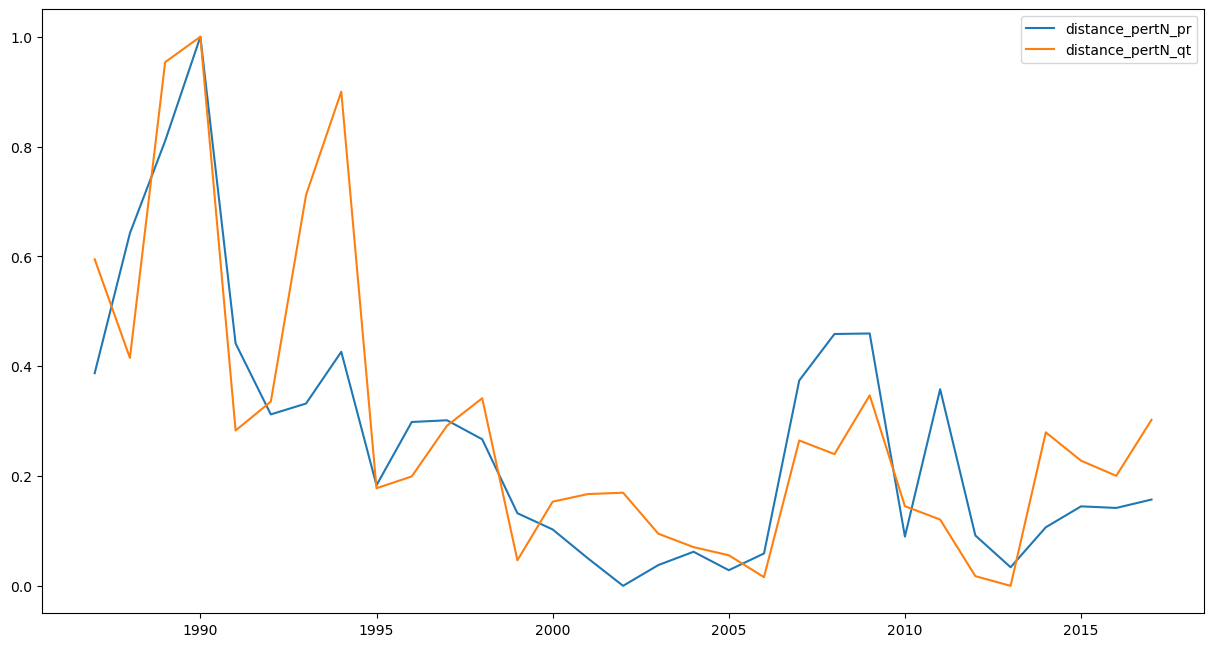

In [21]:
dfperts.plot(y=[x for x in dfperts.columns if x[:len('distance')]=='distance'], figsize=(15, 8))

In [22]:
# CONSTRUCTION OF NETWORK 


%matplotlib inline
import networkx as nx
lg = []    #  lg = list of graphs:  a network (graph) for each year
for year in range(1986, 2018):
    G = nx.MultiDiGraph(weighted=True)
    for index, row in df.loc[df['Year']==year].iterrows():
        if row['Element']=='Import Quantity':
            G.add_edge( row['exporter'], row['importer'], row['Item'], weight=row['Value'] )
        else:
            G[row['exporter']][row['importer']][row['Item']]['value'] = row['Value']
    lg += [G]


In [23]:
#  create a dictionary with amount of trade per country
    # quantity = Total imports 
    # mean_val = Average price     
    
items = df.groupby('Item').groups.keys()
dict_country = {}            
pc = df.groupby('Year')  # pc = Per Country 

for name, group in df.groupby('importer'):
    dict_country[name] = {}
    
for name, group in df.groupby('exporter'):
    if name not in dict_country.keys():
        dict_country[name] = {}

year = int(1986)
for G in lg:
    for x in G.nodes():
        dict_country[x][year] = {}
        for y in G.out_edges(x):        
            for key, val in G[y[0]][y[1]].items():
                for k, v in val.items():
                    dict_country[x][year]['exp_'+key+'_'+k] = v
        for y in G.in_edges(x):
            for key, val in G[y[0]][y[1]].items():
                for k, v in val.items():
                    dict_country[x][year]['imp_'+key+'_'+k] = v
    year += 1

In [24]:
def nrml_(a):   # Normalize in [-1,1]
    return 2*(a - a.min()) / (a.max() - a.min()) -1

In [25]:
for key, val in dict_country.items():
    xxx = pd.DataFrame(val).transpose()
    for col in xxx.columns:
        xxx[col] = nrml(xxx[col])
        xxx['dlt_'+col] = xxx[col] - xxx[col].shift(1)
        xxx['dlt_'+col] = nrml_(xxx['dlt_'+col])
    for year in range(1987, 2018):
        try:
            dict_country[key][year]['dlt_in_pr'] = xxx.drop([xc for xc in xxx.columns if 'dlt_imp_' != xc[:8] or '_value' not in xc ], axis=1).transpose()[year].mean()
            dict_country[key][year]['dlt_in_vl'] = xxx.drop([xc for xc in xxx.columns if 'dlt_imp_' != xc[:8] or '_weight' not in xc ], axis=1).transpose()[year].mean()
            dict_country[key][year]['dlt_ex_pr'] = xxx.drop([xc for xc in xxx.columns if 'dlt_exp_' != xc[:8] or '_value' not in xc ], axis=1).transpose()[year].mean()
            dict_country[key][year]['dlt_ex_vl'] = xxx.drop([xc for xc in xxx.columns if 'dlt_exp_' != xc[:8] or '_weight' not in xc ], axis=1).transpose()[year].mean()
        except: 
            print (key, year)

Afghanistan 1988
Armenia 1987
Armenia 1988
Armenia 1989
Armenia 1990
Armenia 1991
Armenia 1992
Armenia 1993
Armenia 1994
Armenia 1995
Armenia 1996
Aruba 1987
Aruba 1988
Aruba 1989
Aruba 1992
Aruba 2013
Azerbaijan 1987
Azerbaijan 1988
Azerbaijan 1989
Azerbaijan 1990
Azerbaijan 1991
Azerbaijan 1993
Azerbaijan 1994
Azerbaijan 1996
Bahamas, The 1987
Bahamas, The 1988
Bahamas, The 1989
Bahamas, The 1990
Bahamas, The 1991
Bahamas, The 1993
Bahamas, The 1996
Bahrain 1987
Bahrain 1988
Bahrain 1991
Bahrain 1992
Bahrain 1994
Bangladesh 1987
Bangladesh 1988
Bangladesh 1990
Belgium 1987
Belgium 1988
Belgium 1989
Belgium 1990
Belgium 1991
Belgium 1992
Belgium 1993
Belgium 1994
Belgium 1995
Belgium 1996
Belgium 1997
Belgium 1998
Belgium 1999
Belgium-Luxembourg 2000
Belgium-Luxembourg 2001
Belgium-Luxembourg 2003
Belgium-Luxembourg 2004
Belgium-Luxembourg 2005
Belgium-Luxembourg 2006
Belgium-Luxembourg 2007
Belgium-Luxembourg 2008
Belgium-Luxembourg 2009
Belgium-Luxembourg 2010
Belgium-Luxembourg 201

Qatar 1987
Qatar 1988
Qatar 1990
Russia 1987
Russia 1988
Russia 1989
Russia 1990
Russia 1991
Rwanda 1987
Rwanda 1988
Rwanda 1989
Rwanda 1990
Rwanda 1991
Rwanda 1992
Rwanda 1994
Rwanda 2004
Réunion 1997
Réunion 1999
Réunion 2000
Réunion 2001
Réunion 2002
Réunion 2003
Réunion 2004
Réunion 2005
Réunion 2006
Réunion 2007
Réunion 2008
Réunion 2009
Réunion 2010
Réunion 2011
Réunion 2012
Réunion 2013
Réunion 2014
Réunion 2015
Réunion 2016
Réunion 2017
Sao Tome and Principe 1988
Sao Tome and Principe 1989
Sao Tome and Principe 1990
Sao Tome and Principe 1992
Sao Tome and Principe 1995
Sao Tome and Principe 1996
Sao Tome and Principe 1997
Sao Tome and Principe 1998
Sao Tome and Principe 1999
Sao Tome and Principe 2000
Sao Tome and Principe 2002
Sao Tome and Principe 2004
Sao Tome and Principe 2008
Sao Tome and Principe 2011
Serbia 1987
Serbia 1988
Serbia 1989
Serbia 1990
Serbia 1991
Serbia 1992
Serbia 1993
Serbia 1994
Serbia 1995
Serbia 1996
Serbia 1997
Serbia 1998
Serbia 1999
Serbia 2000
Serbi

Czechoslovakia 1993
Czechoslovakia 1996
Czechoslovakia 1997
Czechoslovakia 1998
Czechoslovakia 2000
Czechoslovakia 2001
Czechoslovakia 2002
Czechoslovakia 2003
Czechoslovakia 2004
Czechoslovakia 2005
Czechoslovakia 2006
Czechoslovakia 2007
Czechoslovakia 2008
Czechoslovakia 2009
Czechoslovakia 2010
Czechoslovakia 2011
Czechoslovakia 2012
Czechoslovakia 2013
Czechoslovakia 2014
Czechoslovakia 2015
Czechoslovakia 2016
Czechoslovakia 2017
Dominican Republic 1987
Dominican Republic 1988
Equatorial Guinea 1987
Equatorial Guinea 1988
Equatorial Guinea 1989
Equatorial Guinea 1990
Equatorial Guinea 1992
Equatorial Guinea 1993
Equatorial Guinea 1994
Equatorial Guinea 1996
Equatorial Guinea 1997
Equatorial Guinea 1998
Equatorial Guinea 2000
Equatorial Guinea 2001
Equatorial Guinea 2002
Equatorial Guinea 2003
Equatorial Guinea 2004
Equatorial Guinea 2005
Equatorial Guinea 2006
Equatorial Guinea 2007
Equatorial Guinea 2009
Equatorial Guinea 2010
Equatorial Guinea 2011
Equatorial Guinea 2012
Equato

Puerto Rico 2000
Puerto Rico 2001
Puerto Rico 2002
Puerto Rico 2003
Puerto Rico 2004
Puerto Rico 2005
Puerto Rico 2006
Puerto Rico 2007
Puerto Rico 2008
Puerto Rico 2009
Puerto Rico 2010
Puerto Rico 2011
Puerto Rico 2012
Puerto Rico 2013
Puerto Rico 2014
Puerto Rico 2015
Puerto Rico 2016
Puerto Rico 2017
Saint Helena, Ascension and Tristan da Cunha 1987
Saint Helena, Ascension and Tristan da Cunha 1988
Saint Helena, Ascension and Tristan da Cunha 1990
Saint Helena, Ascension and Tristan da Cunha 1991
Saint Helena, Ascension and Tristan da Cunha 1992
Saint Helena, Ascension and Tristan da Cunha 1993
Saint Helena, Ascension and Tristan da Cunha 1994
Saint Helena, Ascension and Tristan da Cunha 1995
Saint Helena, Ascension and Tristan da Cunha 1997
Saint Helena, Ascension and Tristan da Cunha 1998
Saint Helena, Ascension and Tristan da Cunha 1999
Saint Helena, Ascension and Tristan da Cunha 2000
Saint Helena, Ascension and Tristan da Cunha 2001
Saint Helena, Ascension and Tristan da Cunha

In [26]:
dictotal = {} 
i = 0
j = 0
lp = []
for country in dict_country.keys():
    dictotal[country] = {}
    for year in dict_perts.keys():
        dictotal[country][year] = {}
        try:
            dictotal[country][year]['distance_af_in_pr'] = -1*dict_country[country][year]['dlt_in_pr'] * dict_perts[year]['distance_pertN_pr']
            dictotal[country][year]['distance_af_in_vl'] = -1*dict_country[country][year]['dlt_in_vl'] * dict_perts[year]['distance_pertN_qt']
            dictotal[country][year]['distance_af_ex_pr'] = dict_country[country][year]['dlt_ex_pr'] * dict_perts[year]['distance_pertN_pr']
            dictotal[country][year]['distance_af_ex_vl'] = dict_country[country][year]['dlt_ex_vl'] * dict_perts[year]['distance_pertN_qt']
            dictotal[country][year]['distance_af_in_pr2'] = -1*dict_country[country][year]['dlt_in_pr'] * (dict_perts[year]['distance_pertN_pr'] + dict_perts[year]['distance_pertN_qt'])/2
            dictotal[country][year]['distance_af_in_vl2'] = -1*dict_country[country][year]['dlt_in_vl'] * (dict_perts[year]['distance_pertN_pr'] + dict_perts[year]['distance_pertN_qt'])/2
            dictotal[country][year]['distance_af_ex_pr2'] = dict_country[country][year]['dlt_ex_pr'] * (dict_perts[year]['distance_pertN_pr'] + dict_perts[year]['distance_pertN_qt'])/2
            dictotal[country][year]['distance_af_ex_vl2'] = dict_country[country][year]['dlt_ex_vl'] * (dict_perts[year]['distance_pertN_pr'] + dict_perts[year]['distance_pertN_qt'])/2
            
        except:
            j += 1
            lp += [country]
        i += 1
print('total loops = ',i, 'total exceptions = ',j)

total loops =  7502 total exceptions =  1884


In [48]:
tk = {}
for key, val in dictotal.items():
    tk[key] = {}
    ddff = pd.DataFrame(val).transpose()
    for col in ddff.columns:
        tk[key][col] = ddff[col].mean()

In [51]:
afs = pd.DataFrame(tk).transpose()
# afs.to_csv('distan_datasets/distances_af_percountry.csv')

In [33]:
grc = df.groupby('importer')
for name, group in grc: 
    qt = group.loc[group['Element'] == 'Import Quantity']
    tk[name]['tot_imp_qt'] = np.sum(qt['Value'])
    vl = group.loc[group['Element'] == 'Import Value']
    tk[name]['tot_imp_vl'] = np.sum(vl['Value'])

grc = df.groupby('exporter')
for name, group in grc: 
    qt = group.loc[group['Element'] == 'Import Quantity']
    tk[name]['tot_exp_qt'] = np.sum(qt['Value'])
    vl = group.loc[group['Element'] == 'Import Value']
    tk[name]['tot_exp_vl'] = np.sum(vl['Value'])

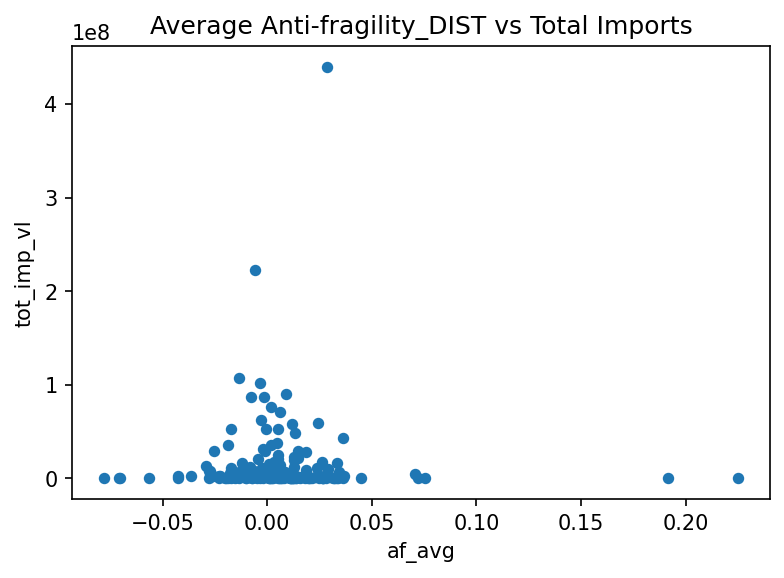

In [45]:
ttk = pd.DataFrame(tk).transpose().drop(['tot_imp_qt', 'tot_imp_vl', 'tot_exp_qt', 'tot_exp_vl'], axis=1)
ttk = ttk[['distance_af_in_pr', 'distance_af_in_vl', 'distance_af_ex_pr', 'distance_af_ex_vl',
       'distance_af_in_pr2', 'distance_af_in_vl2', 'distance_af_ex_pr2', 'distance_af_ex_vl2']]

tttk = pd.DataFrame(tk).transpose()
tttk['af_avg'] = ttk.transpose().describe().transpose()['mean']

tttk.plot(kind='scatter', y='tot_imp_vl', x='af_avg', figsize=(6,4), title="Average Anti-fragility_DIST vs Total Imports")

# plt.savefig('distancias_plots/Average_antifragilitydistancias_vsImports.png')

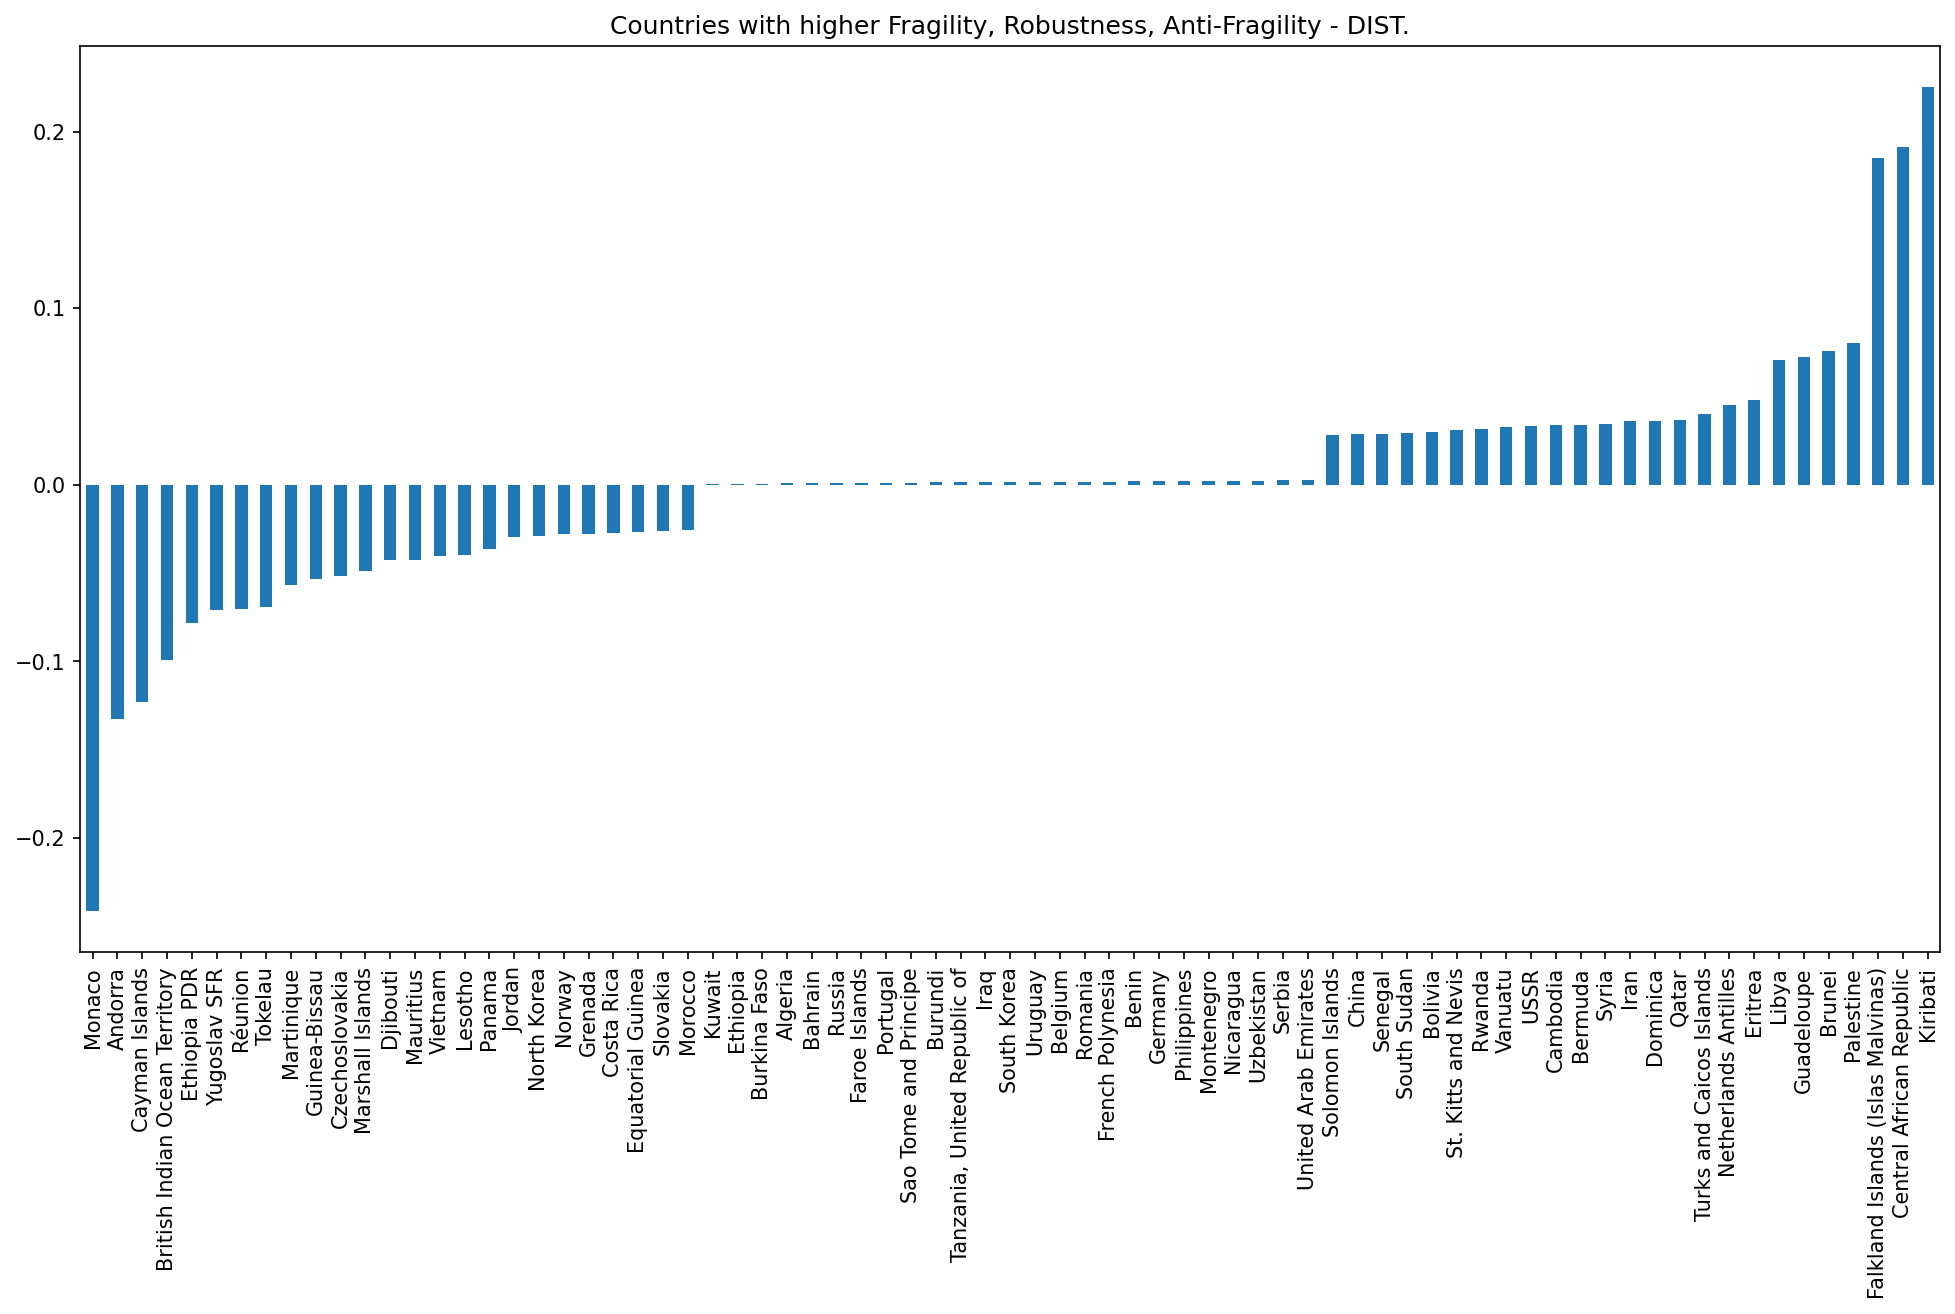

In [46]:
ttk.drop([col for col in ttk.columns if 'in' not in col], axis=1)
top = ttk.transpose().describe().transpose()['mean'].sort_values().head(int(25)) #.plot(kind='bar', figsize=(16,8))
bot = ttk.transpose().describe().transpose()['mean'].dropna().sort_values().tail(int(25)) #.plot(kind='bar', figsize=(16,8))
med = ttk.transpose().describe().transpose()['mean'].abs().sort_values().head(int(25))#.plot(kind='bar', figsize=(16,8))
top.append(med.append(bot)).plot(kind='bar', figsize=(16,8), title="Countries with higher Fragility, Robustness, Anti-Fragility - DIST.")
# plt.savefig('distancias_plots/Higer_countries_FRA_distance.png')

In [53]:
import networkx as nx

In [54]:
DG=nx.Graph()

In [72]:
DG.add_weighted_edges_from([tuple(edge) for edge in df_distances.values])

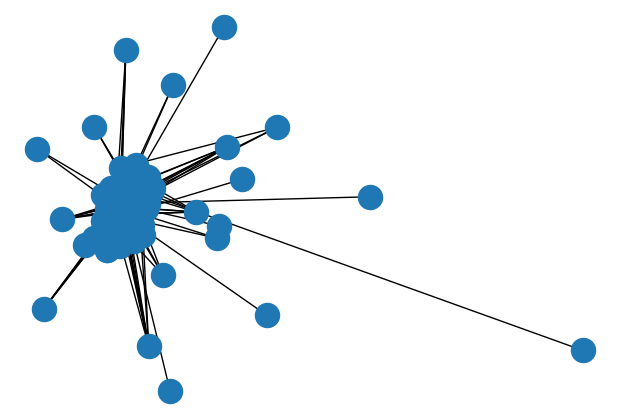

In [84]:
nx.draw(DG)